In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install prettytensor
!pip install tensorlayer

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import pandas
import tensorlayer as tl
from datetime import timedelta
import os
from sklearn.model_selection import train_test_split
import drive.app.inception as inception
import prettytensor as pt

In [0]:
def read_data_sets():
    print("Reading Data")
    labels = pandas.read_csv("drive/app/trainLabels.csv")
    y = np.array([label for label in labels['level']])
    X = np.load("drive/app/X_train.npy")
    print("Splitting data into test/ train datasets")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = pandas.get_dummies(y_train)
    y_train = np.array(y_train,dtype= 'float32')
    y_test = pandas.get_dummies(y_test)
    y_test = np.array(y_test,dtype= 'float32')
    X_train = X_train.reshape(X_train.shape[0],256,256,3)
    X_test = X_test.reshape(X_test.shape[0],256,256,3)
    return X_train,y_train,X_test,y_test 

In [0]:
# Loading data to training set and testing set
images_train, labels_train, images_test, labels_test = read_data_sets()

Reading Data
Splitting data into test/ train datasets


In [0]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

In [8]:
# load Inception model
inception.maybe_download()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [0]:
model = inception.Inception()

In [0]:
from drive.app.inception import transfer_values_cache

In [0]:
file_path_cache_train = os.path.join('drive/app/train_split1/', 'inception_dr_train1.pkl')
file_path_cache_test = os.path.join('drive/app/train_split1/', 'inception_dr_test1.pkl')

In [0]:
x_train = np.array([])

In [13]:
# Processing transfer values of training set
print("Processing Inception transfer-values for training-images ...")
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train1,
                                              images=images_train,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Data loaded from cache-file: drive/app/train_split1/inception_dr_train1.pkl


In [16]:
# Processing transfer values of testing set
print("Processing Inception transfer-values for test-images ...")
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=x_train,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Data loaded from cache-file: drive/app/train_split1/inception_dr_test1.pkl


In [17]:
transfer_values_train.shape

(41123, 2048)

In [18]:
transfer_values_test.shape

(10149, 2048)

In [0]:
def plot_transfer_values(i):
    print("Input image:")
    plt.imshow(images_test[i], interpolation='nearest')
    plt.show()

    print("Transfer-values for the image using Inception model:")
    img = transfer_values_test[i]
    img = img.reshape((32, 64))
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


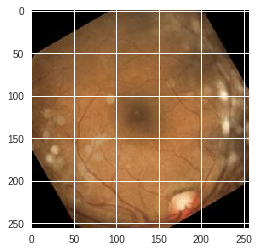

Transfer-values for the image using Inception model:


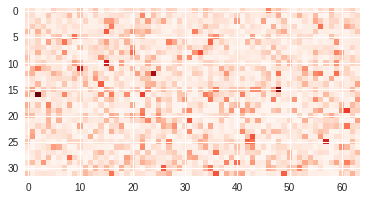

In [0]:
plot_transfer_values(i=16)

In [0]:
transfer_len = model.transfer_len

In [0]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

In [0]:
y_true = tf.placeholder(tf.float32, shape=[None, 5], name='y_true')

In [0]:
y_true_cls = tf.argmax(y_true, axis=1)

In [0]:
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(x, 1024, activation = tf.nn.relu,
                          name = "fc1")
with tf.name_scope("drop"):
  drop_out = tf.nn.dropout(fc1, 0.5) 
with tf.name_scope("output"):
    logits = tf.layers.dense(drop_out, 5, name = "output")
    Y_pred = tf.nn.softmax(logits, name="Y_pred")

In [0]:
tf.reset_default_graph()

In [0]:
with tf.name_scope("train"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

In [0]:
y_pred_cls = tf.argmax(Y_pred, axis=1)

In [0]:
with tf.name_scope("eval"):
    correct = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [0]:
x_fashion_train = transfer_values_train
y_fashion_train = labels_train

In [0]:
with tf.name_scope("init"):
    session = tf.Session()
    session.run(tf.global_variables_initializer())

In [32]:
n_epochs = 100
step_par_epoch = 100
batch_size = 500
loss_list=[]
accu = []
loss_test_list=[]
accu_test = []
for epoch in range(n_epochs):
    for step in range(step_par_epoch):
        for iteration in range(len(transfer_values_train) // batch_size):
            #this cycle is for dividing step by step the heavy work of each neuron
            X_batch = x_fashion_train[iteration*batch_size:iteration*batch_size+batch_size]
            y_batch = y_fashion_train[iteration*batch_size:iteration*batch_size+batch_size]
            session.run(training_op, feed_dict={x: X_batch, y_true: y_batch})
        _,loss_value = session.run([training_op,loss],feed_dict={x: X_batch, y_true: y_batch})
        acc_train = session.run(accuracy,feed_dict={x: X_batch, y_true: y_batch})
        loss_list.append(loss_value)
        accu.append(acc_train)
        acc_test = session.run(accuracy,feed_dict={x:transfer_values_test,y_true: labels_test})
        accu_test.append(acc_test) 
        print("Epoch:",epoch+1, "Train accuracy:", acc_train," loss train:",loss_value, "Test accuracy:",acc_test)

np.savetxt("drive/app/loss_train_incep1.txt",loss_list)
np.savetxt("drive/app/accu_train_incep1.txt",accu)
np.savetxt("drive/app/accu_test_incep1.txt",accu_test)

Epoch: 1 Train accuracy: 0.806  loss train: 0.5085952 Test accuracy: 0.6633166
Epoch: 2 Train accuracy: 0.826  loss train: 0.39628437 Test accuracy: 0.673958
Epoch: 3 Train accuracy: 0.84  loss train: 0.4082423 Test accuracy: 0.66252834
Epoch: 4 Train accuracy: 0.83  loss train: 0.37113854 Test accuracy: 0.6679476
Epoch: 5 Train accuracy: 0.83  loss train: 0.3839017 Test accuracy: 0.6609518
Epoch: 6 Train accuracy: 0.828  loss train: 0.38888347 Test accuracy: 0.6653857
Epoch: 7 Train accuracy: 0.832  loss train: 0.35567212 Test accuracy: 0.6572076
Epoch: 8 Train accuracy: 0.842  loss train: 0.3548201 Test accuracy: 0.6523796
Epoch: 9 Train accuracy: 0.862  loss train: 0.33063614 Test accuracy: 0.6493251
Epoch: 10 Train accuracy: 0.834  loss train: 0.3391988 Test accuracy: 0.666174
Epoch: 11 Train accuracy: 0.844  loss train: 0.32286146 Test accuracy: 0.6558282
Epoch: 12 Train accuracy: 0.844  loss train: 0.27821717 Test accuracy: 0.64902943
Epoch: 13 Train accuracy: 0.848  loss train: 

In [34]:
# Save model
saver = tf.train.Saver()
save_path = saver.save(session, "drive/app/train_split1/inception_weight.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: drive/app/train_split1/inception_weight.ckpt


In [0]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = images_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]

    n = min(9, len(images))
    plot_images(images=images[0:n],
                cls_true=cls_true[0:n],
                cls_pred=cls_pred[0:n])

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    for i in range(5):
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    class_numbers = [" ({0})".format(i) for i in range(5)]
    print("".join(class_numbers))

In [0]:
batch_size = 200

def predict_cls(transfer_values, labels, cls_true):
    num_images = len(transfer_values)
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    i = 0

    while i < num_images:
        j = min(i + batch_size, num_images)
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
        
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [0]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

In [0]:
cls_test = np.asarray([np.where(r==1)[0][0] for r in labels_test])

In [0]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

In [0]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    correct, cls_pred = predict_cls_test()
    acc, num_correct = classification_accuracy(correct)
    num_images = len(correct)
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [0]:
class_names=['0','1','2','3','4']

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)
    fig, axes = plt.subplots(3, 3)
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i],
                      interpolation=interpolation)
            cls_true_name = class_names[cls_true[i]]
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [44]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

Accuracy on Test-Set: 67.0% (6800 / 10149)
Confusion Matrix:
[4024  293  514   40   25] (0) 0
[271 756 294  31   2] (1) 1
[ 680  390 1744  133   58] (2) 2
[ 63  33 236 141  31] (3) 3
[ 38  20 158  39 135] (4) 4
 (0) (1) (2) (3) (4)
